In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_excel("marketing_data.xlsx")

In [3]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

In [4]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

In [5]:
df.shape

(2240, 22)

In [6]:
#combine amount spent
df['MntSpent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] 
+ df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

0       518
1        44
2        47
3         0
4        45
       ... 
2235    173
2236     27
2237     34
2238    377
2239    332
Length: 2240, dtype: int64

In [7]:
#combine number of purchases without deals
df['NumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [8]:
#Standardize Dt_Customer
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%y')

In [9]:
#birthyear should always occur before Dt_customer
mask = df['Year_Birth'] <= df['Dt_Customer'].dt.year
print(mask)
df = df[mask]

0       True
1       True
2       True
3       True
4       True
        ... 
2235    True
2236    True
2237    True
2238    True
2239    True
Length: 2240, dtype: bool


In [10]:
#convert birthyear into Age
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']

In [11]:
#convert Dt_Customer into numerical value
current_date = pd.Timestamp.now()
df['DaysEnrolled'] = (current_date - df['Dt_Customer']).dt.days

In [12]:
#Standardize Marital Status
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'YOLO', 'Absurd'], 'Single')

In [13]:
#MntSpent should not be more than the household income
mask = df['MntSpent'] <= df['Income']
print(mask)
df = df[mask]

0       True
1       True
2       True
3       True
4       True
        ... 
2235    True
2236    True
2237    True
2238    True
2239    True
Length: 2240, dtype: bool


In [14]:
#Take features and target to use
df = df.drop(['ID', 'Dt_Customer', 'Year_Birth', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'], axis=1)
df.dtypes

Education             object
Marital_Status        object
Income               float64
Recency                int64
NumDealsPurchases      int64
Response               int64
Complain               int64
MntSpent               int64
NumPurchases           int64
Age                    int64
DaysEnrolled           int64
dtype: object

### Outliers Removal

In [15]:
def remove_outliers(df, column, z_threshold=3):
    # Calculate Z-Score for the specified column
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

    # Create a mask for rows with outliers in the specified column
    outliers_mask = z_scores > z_threshold

    # Remove rows with outliers from the DataFrame
    cleaned_df = df[~outliers_mask]

    return cleaned_df

<Axes: xlabel='MntSpent', ylabel='Income'>

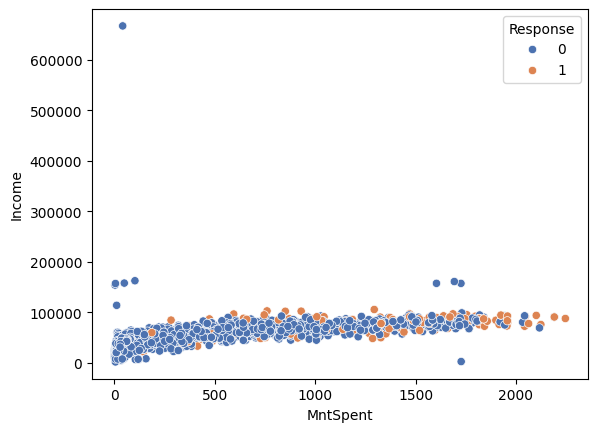

In [16]:
sns.scatterplot(data=df, x='MntSpent', y='Income', hue='Response', palette='deep')

In [17]:
df = remove_outliers(df, 'Income', 3)
df = remove_outliers(df, 'MntSpent', 3)

<Axes: xlabel='MntSpent', ylabel='Income'>

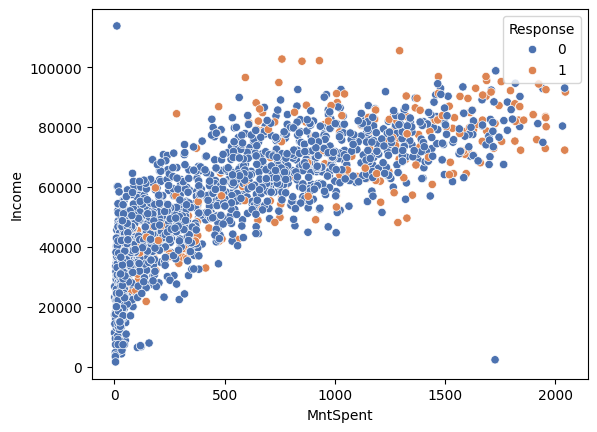

In [18]:
sns.scatterplot(data=df, x='MntSpent', y='Income', hue='Response', palette='deep')

In [19]:
# mean fill the null values 
mean_income = df['Income'].mean()
df['Income'] = df['Income'].fillna(mean_income)

### One-Hot Encoding for Categorical Values

In [20]:
def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True) 
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

In [21]:
df = one_hot_encode(df, 'Marital_Status')

### Ordinal Encoding for Education Status

In [22]:
ranking_order = {'Basic': 1, 'Graduation': 2, '2n Cycle': 3, 'Master': 4, 'PhD': 5}
df['Education'] = df['Education'].map(ranking_order)

In [23]:
df.isnull().sum()

Education            0
Income               0
Recency              0
NumDealsPurchases    0
Response             0
Complain             0
MntSpent             0
NumPurchases         0
Age                  0
DaysEnrolled         0
Married              0
Single               0
Together             0
Widow                0
dtype: int64

In [24]:
df.shape

(2201, 14)

In [25]:
df.to_parquet('clean.parquet')